## Dependencies 

In [575]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [576]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [577]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from itertools import cycle
import itertools
import random 
from statistics import stdev

## Plotting code

In [578]:
import json

def read_json_data(file_path):
    try:
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None



def print_streaming_eval(json_data):
    # Accessing the 'id' field at the top level
    id_value = json_data.get('id')
    if id_value:
        print(f"ID: {id_value}")

    # Accessing fields within the 'runs' list
    runs = json_data.get('runs', [])
    for run in runs:
        range_value = run.get('range')
        slide_value = run.get('slide')
        systems = run.get('systems', [])

        print(f"Range: {range_value}, Slide: {slide_value}")

        for system in systems:
            system_id = system.get('id')
            throughput = system.get('throughput')
            runtime = system.get('runtime')

            print(f"System ID: {system_id}, Throughput: {throughput}, Runtime: {runtime}")

            # Accessing fields within 'insert_latency', 'query_latency', and 'advance_latency' dictionaries
            insert_latency = system.get('insert_latency', {})
            query_latency = system.get('query_latency', {})
            advance_latency = system.get('advance_latency', {})

            p50_insert = insert_latency.get('p50')
            p50_query = query_latency.get('p50')
            p50_advance = advance_latency.get('p50')

            p95_insert = insert_latency.get('p95')
            p95_query = query_latency.get('p95')
            p95_advance = advance_latency.get('p95')
    
            
            avg_insert = insert_latency.get('sum') / insert_latency.get('count')
            avg_query = query_latency.get('sum') / query_latency.get('count')
            avg_advance = advance_latency.get('sum') / advance_latency.get('count')

            print(f"AVG Insert: {avg_insert}, AVG Query: {avg_query}, AVG Advance: {avg_advance}")
            print(f"P50 Insert Latency: {p50_insert}, P50 Query Latency: {p50_query}, P50 Advance Latency: {p50_advance}")
            print(f"P95 Insert Latency: {p95_insert}, P95 Query Latency: {p95_query}, P95 Advance Latency: {p95_advance}")



In [579]:
import matplotlib.pyplot as plt
import numpy as np

def plot_workload_distribution(json_data, fixed_range: bool):
    runs = json_data.get('runs', [])

    # Initialize lists to store data for plotting
    x_labels = []  # Range values for the x-axis
    insert_distribution = []  # Data for insert distribution
    advance_distribution = []  # Data for advance distribution
    query_distribution = []  # Data for query distribution

    for run in runs:
        #range_value = run.get('range')
        x_value = ''
        if fixed_range:
            x_value = run.get('range')
        else:
            x_value = run.get('slide')
            
        x_labels.append(x_value)

        systems = run.get('systems', [])
        insert_dist_sum = 0
        advance_dist_sum = 0
        query_dist_sum = 0

        system = systems[0]
        insert_dist = system.get('insert_distribution', 0)
        advance_dist = system.get('advance_distribution', 0)
        query_dist = system.get('query_distribution', 0)
        insert_dist_sum += insert_dist
        advance_dist_sum += advance_dist
        query_dist_sum += query_dist

        insert_distribution.append(insert_dist_sum)
        advance_distribution.append(advance_dist_sum)
        query_distribution.append(query_dist_sum)

    # Create stacked bar plots
    plt.figure(figsize=(10, 6))
    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions

    #fig, ax = plt.subplots()
    bar_width = 0.35
    insert_bars = plt.bar(x_ticks, insert_distribution, width=bar_width, label='Insert', alpha=0.8)
    advance_bars = plt.bar(x_ticks, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.8)
    query_bars = plt.bar(x_ticks, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.8)
    #plt.bar(x_labels, insert_distribution, width=bar_width, label='Insert', alpha=0.7)
    #plt.bar(x_labels, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.7)
    #plt.bar(x_labels, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.7)
    

    
    # Add labels and legend
   
    if fixed_range:
        plt.xlabel('Window Range')
        plt.title('Fixed Window Slide 2s')
    else:
        plt.xlabel('Window Slide')
        plt.title('Fixed Window Range 30 minute')
    
    plt.ylabel('Workload Distribution (%)')
    plt.xticks(x_ticks, x_labels)
    

    #plt.title('Workload Distribution for Each Run')
    #plt.legend(loc='upper right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


    # Show the plot
    plt.tight_layout()

    plt.show()

In [580]:
hatches = itertools.cycle(['/', '+', '//', '-', 'x', '\\', '.', '|'])
#hatches = itertools.cycle(['//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**'])

colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#C4da0d'])


In [581]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latency(json_data, fixed_range: bool):
    runs = json_data.get('runs', [])
    latency_types = ['insert_latency', 'query_latency', 'advance_latency']
    subplots_titles = ['Insert', 'Query', 'Advance']
    #hatches = itertools.cycle(['/', '+', '//', '-', 'x', '\\',  '.'])

    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#3E9651'])
    #colors = itertools.cycle(['#5896D1', '#EEC876', '#7661B4', '#5AA56D', '#F17CB0', '#B2912F', '#B44D5E', '#3E9651'])

    fig, [ax1, ax2] = plt.subplots(2, 3, figsize=(10, 5), sharey=True)  # Create a 1x3 grid of subplots
    if fixed_range:
        fig.suptitle('SUM Aggregation Fixed Window Slide 2s')
    else:
        fig.suptitle('SUM Aggregation Fixed Window Range 30m')


    for i, latency_type in enumerate(latency_types):
        ax = ax1[i]  # Select the current subplot
        ax.set_title(subplots_titles[i])

        x_labels = []  # Range values for the x-axis
        system_latencies = {}  # Dictionary to store latency data for each system

        for run in runs:
            x_value = ''
            if fixed_range:
                x_value = run.get('range')
            else:
                x_value = run.get('slide')
            
            x_labels.append(x_value)

            systems = run.get('systems', [])

            for system in systems:
                system_id = system.get('id')
                latency_data = system.get(latency_type)
                if system_id not in system_latencies:
                    system_latencies[system_id] = []
                system_latencies[system_id].append((range_value, latency_data['p95']))

        # Define custom x-axis positions for the ticks
        x_ticks = np.arange(len(x_labels))

        bar_width = 0.10  # Width of the bars
        num_systems = len(system_latencies)

        for j, (system_id, latencies) in enumerate(system_latencies.items()):
            x_positions = x_ticks + (j - (num_systems - 1) / 2) * bar_width
            range_values, values = zip(*latencies)

            ax.bar(x_positions, values, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches))

        # Set custom x-axis tick positions and labels
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)

        # Add labels and legend for the current subplot
        #ax.set_xlabel('Window Range')
        #ax.set_ylabel('p95 latency (nanoseconds)')
        #ax.legend()
        
        for i, latency_type in enumerate(latency_types):
            ax = ax2[i]  # Select the current subplot
            #ax.set_title(subplots_titles[i])
            x_labels = []  # Range values for the x-axis
            system_latencies = {}  # Dictionary to store latency data for each system
            for run in runs:
                x_value = ''
                if fixed_range:
                    x_value = run.get('range')
                else:
                    x_value = run.get('slide')
            
                x_labels.append(x_value)

                
                systems = run.get('systems', [])
                
                for system in systems:
                    system_id = system.get('id')
                    latency_data = system.get(latency_type)
                    if system_id not in system_latencies:
                        system_latencies[system_id] = []
                    system_latencies[system_id].append((range_value, latency_data['sum'] / latency_data['count']))
            x_ticks = np.arange(len(x_labels))
            bar_width = 0.10  # Width of the bars
            num_systems = len(system_latencies)
            for j, (system_id, latencies) in enumerate(system_latencies.items()):
                x_positions = x_ticks + (j - (num_systems - 1) / 2) * bar_width
                range_values, values = zip(*latencies)
                ax.bar(x_positions, values, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches))
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_labels)
            if fixed_range:
                ax.set_xlabel('Window Range')
            else:
                ax.set_xlabel('Window Slide')
        #ax.set_ylabel('avg latency (nanoseconds)')
    
    # Adjust the layout of subplots
    #plt.title('SUM Aggregation Fixed Window slide 2s')
    plt.tight_layout()
    
    ax1[2].set_yscale('log')
    ax1[0].set_ylabel('p95 latency (nanoseconds)')
    ax2[0].set_ylabel('avg latency (nanoseconds)')
    
    #plt.ylabel('p95 latency (nanoseconds)')
    ax1[0].legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(1.5, 1.7),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)


    # Show the plot
    plt.show()


In [582]:
import matplotlib.pyplot as plt
import numpy as np

def plot_throughput(json_data, fixed_range: bool):    
    runs = json_data.get('runs', [])

    x_labels = []  # Range values for the x-axis
    system_throughputs = {}  # Dictionary to store throughput data for each system

    for run in runs:
        x_value = ''
        if fixed_range:
            x_value = run.get('range')
        else:
            x_value = run.get('slide')
       
        x_labels.append(x_value)
        #print(range_value)

        systems = run.get('systems', [])

        for system in systems:
            system_id = system.get('id')
            throughput = system.get('throughput')
            if system_id not in system_throughputs:
                system_throughputs[system_id] = []
            system_throughputs[system_id].append(throughput)

    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions
    bar_width = 0.10  # Width of the bars
    num_systems = len(system_throughputs)
    
    # Create a bar plot for each system's throughput
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    

    #plt.figure(figsize=(10, 3))
    for i, (system_id, throughputs) in enumerate(system_throughputs.items()):
        x_positions = x_ticks + (i - (num_systems - 1) / 2) * bar_width
        #x_positions = [x - 0.15 if x_labels[j] == "1m" else x for j, x in enumerate(x_positions)]
        #x_positions = i + bar_width
        plt.bar(x_positions , throughputs, width=bar_width, label=system_id, color=next(colors), hatch=next(hatches))

    # Set custom x-axis tick labels
    #plt.xticks([i + 0.3 for i in x_ticks], x_ticks)

    plt.xticks(x_ticks, x_labels)
    #ax1.set_xticks([0, 1])
    #ax1.set_xticklabels([1,2])
    # Add labels and legend
    #plt.xlabel('Window Range')
    if fixed_range:
        plt.xlabel('Window Range')
    else:
        plt.xlabel('Window Slide')
        
    plt.ylabel('Throughput (million event/s)')
    #plt.grid(True)
    
    if fixed_range:
        plt.title('SUM Aggregation Fixed Window slide 2s')
    else:
        plt.title('SUM Aggregation Fixed Window Range 30m')
        
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(0.5, 1.4),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
    plt.show()



# DEBS12 Streaming Window Aggregation

## Growing Window Range

In [583]:
file_path = 'results/debs12.json' 
json_data = read_json_data(file_path)

if json_data:
    print_streaming_eval(json_data)

ID: debs12
Range: 30s, Slide: 2s
System ID: Lazy Wheel 64, Throughput: 16.235876194059422, Runtime: 1.994996612
AVG Insert: 22.037219287447023, AVG Query: 17.3450584179276, AVG Advance: 736.2536291393182
P50 Insert Latency: 21.978242872649467, P50 Query Latency: 15.959309654787097, P50 Advance Latency: 165.69029301849932
P95 Insert Latency: 22.875222481777083, P95 Query Latency: 24.780498769903684, P95 Advance Latency: 262.4697074828635
System ID: Lazy Wheel 512, Throughput: 16.462835883895533, Runtime: 1.967493221
AVG Insert: 21.887696917968402, AVG Query: 17.01166530271108, AVG Advance: 726.4029409767031
P50 Insert Latency: 21.978242872649467, P50 Query Latency: 15.959309654787097, P50 Advance Latency: 165.69029301849932
P95 Insert Latency: 22.875222481777083, P95 Query Latency: 24.780498769903684, P95 Advance Latency: 232.78881637272443
System ID: Eager Wheel W64, Throughput: 16.487895568652927, Runtime: 1.96450286
AVG Insert: 21.78906728197431, AVG Query: 83.01542807891208, AVG Adv

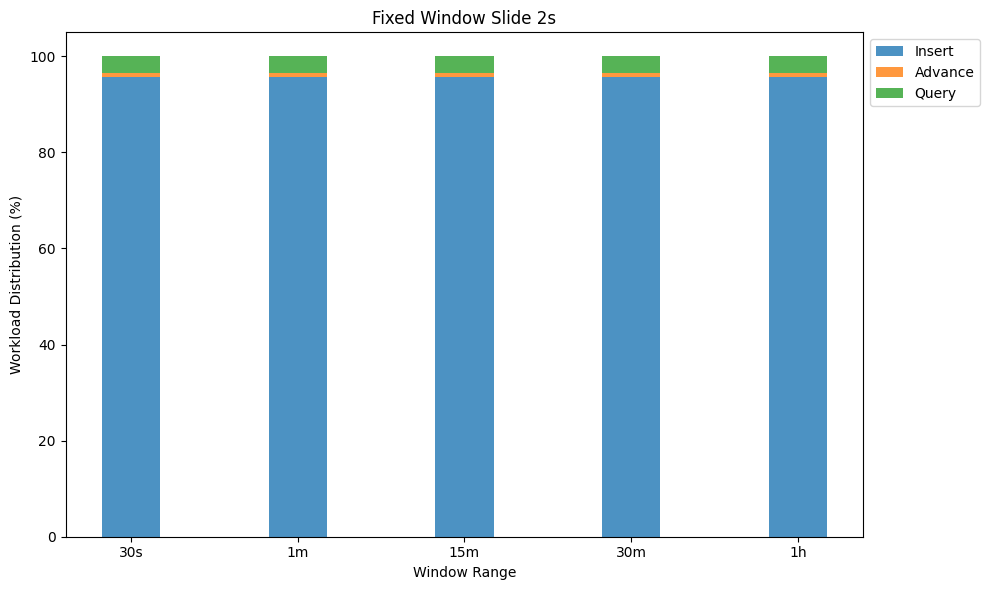

In [584]:
plot_workload_distribution(json_data, True)

## Throughput 

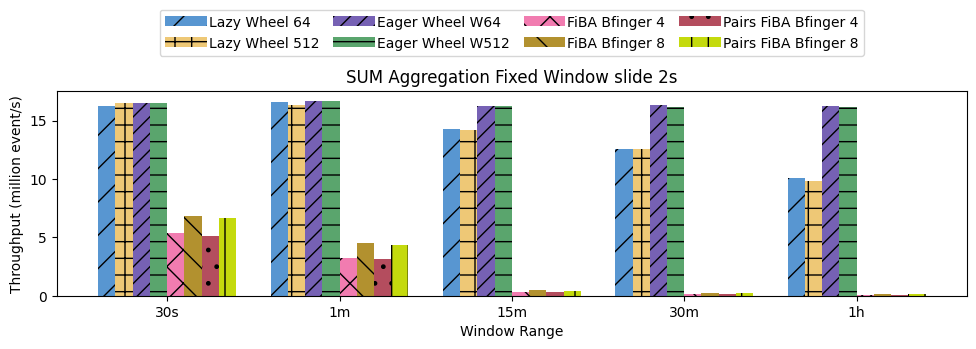

In [585]:
plot_throughput(json_data, True)

### Analysis

Wheels exploit hierarchical nature of time and rolls up aggregates over wheels. FiBA, on the other hand is designed for both **count** and **time** based window measures and is not explicitly optimised for time-based windows. FiBA and its tree has to maintain a larger range of window slices (1s) and when the window ranges grow, rebalances in the tree become more expensive. Therefore the larger window size, the worse performance FiBA will have. 

## Latency

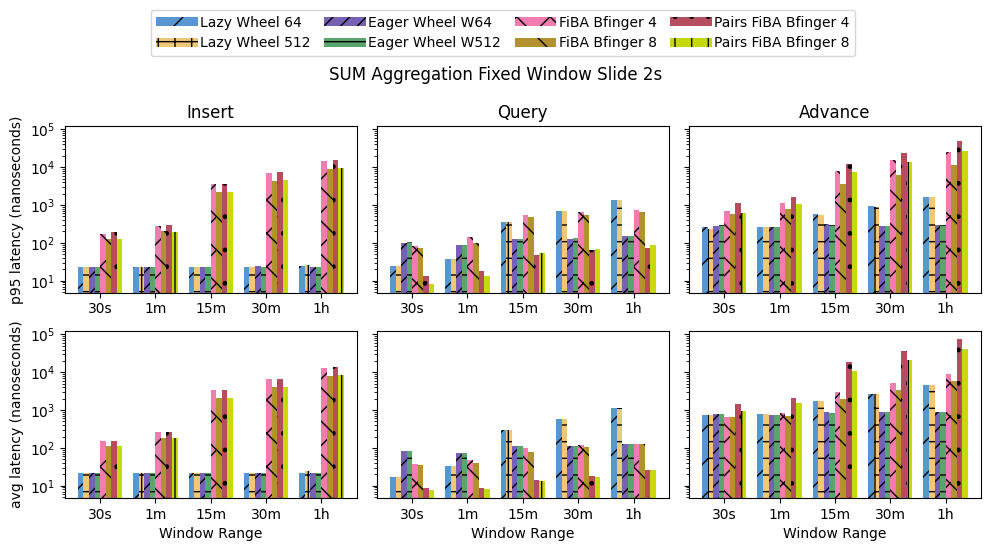

In [586]:
plot_latency(json_data, True)

### Analysis

**Insert Latency**: The results show that the latency of inserts in wheels does not change as the window size increases. This is thanks to the decoupled write and read paths. For FiBA, the insert latency increases when the window size increases and this is due to the tree having to maintain more aggregate nodes (1 per second in our case) as it does not roll-up aggregates over time. A larger tree will exhibit larger rebalance and repair costs.

**Query latency**: Lazy window wheels have to compute in worst-case (2r/s) aggregates using Pairs and it can be observed that the query latency keeps growing when the window range increases. Eager wheels perform worse than its lazy variant when window range is lower meaning that there is less number of pairs to aggregate. The eager version has some extra steps involved. However, as seen in the figure the query latency of eager wheels remain somewhat stable when the window range increases.

**Advance Latency**: The advancement process includes updating the low watermark and it may also include the querying and cleanup of windows.
It can be seen that the cost of advancing with FiBA is more costly as it has to evict and repair more in its tree structure.

**Summary**: Wheels maintain a stable insert latency no matter the window specification as it decouples the write and read paths and performs lazy index maintenance.

## Growing Slide

In [587]:
file_path = 'results/debs12_growing_slide.json' 
debs12_growing_slide_json = read_json_data(file_path)

if json_data:
    print_streaming_eval(debs12_growing_slide_json)

ID: debs12
Range: 30m, Slide: 2s
System ID: Lazy Wheel 64, Throughput: 12.651558432049747, Runtime: 2.56019985
AVG Insert: 21.93867760929294, AVG Query: 571.598828997983, AVG Advance: 2678.439189147469
P50 Insert Latency: 21.978242872649467, P50 Query Latency: 539.2394262082521, P50 Advance Latency: 115.59680764552776
P95 Insert Latency: 22.875222481777083, P95 Query Latency: 699.3618972397379, P95 Advance Latency: 925.3552129773502
System ID: Lazy Wheel 512, Throughput: 12.553148153232526, Runtime: 2.580270511
AVG Insert: 22.005771658236526, AVG Query: 572.5731288145782, AVG Advance: 2693.512599334375
P50 Insert Latency: 21.978242872649467, P50 Query Latency: 539.2394262082521, P50 Advance Latency: 115.59680764552776
P95 Insert Latency: 22.875222481777083, P95 Query Latency: 699.3618972397379, P95 Advance Latency: 925.3552129773502
System ID: Eager Wheel W64, Throughput: 16.43397960400197, Runtime: 1.970947925
AVG Insert: 21.9595381586673, AVG Query: 112.49141134495332, AVG Advance: 8

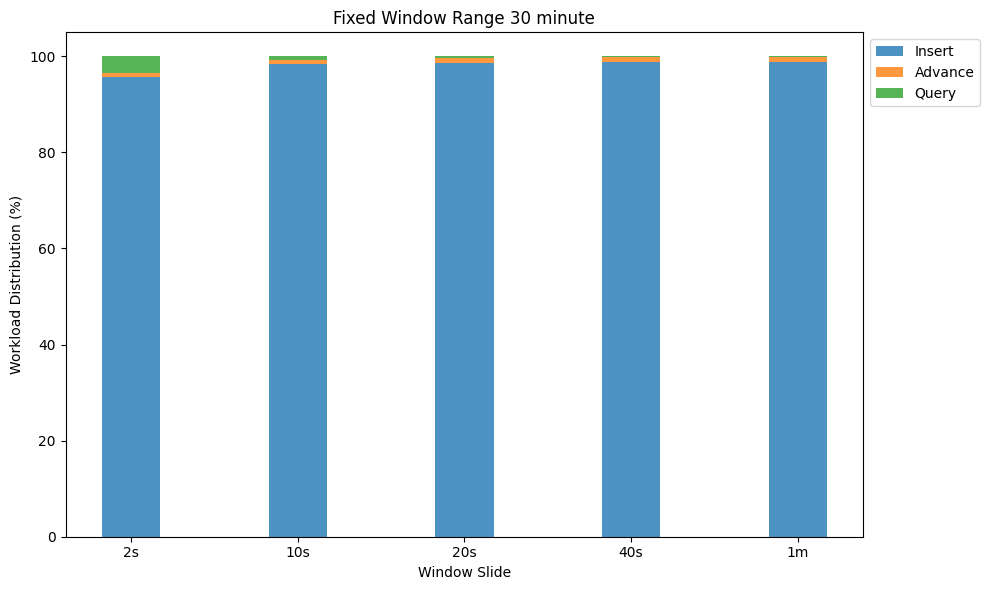

In [588]:
plot_workload_distribution(debs12_growing_slide_json, False)

### Analysis

The DEBS12 dataset has around 100 avg tuples per second and inserts are the dominating operation even when dealing with a larger number of concurrent windows.

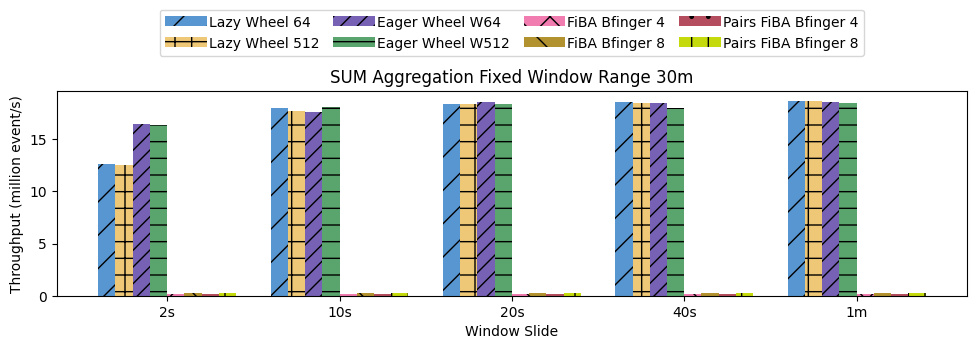

In [589]:
plot_throughput(debs12_growing_slide_json, False)

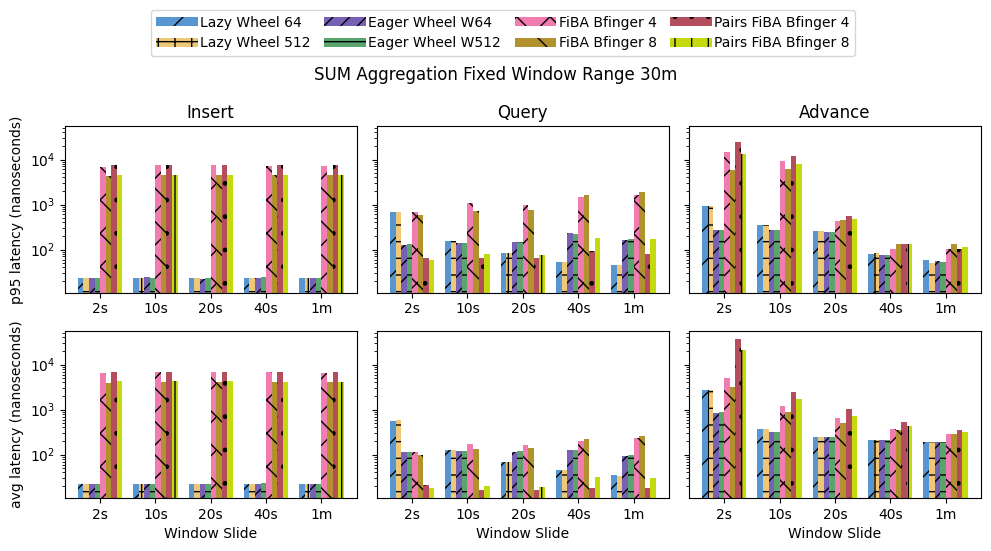

In [590]:
plot_latency(debs12_growing_slide_json, False)

### Old plot

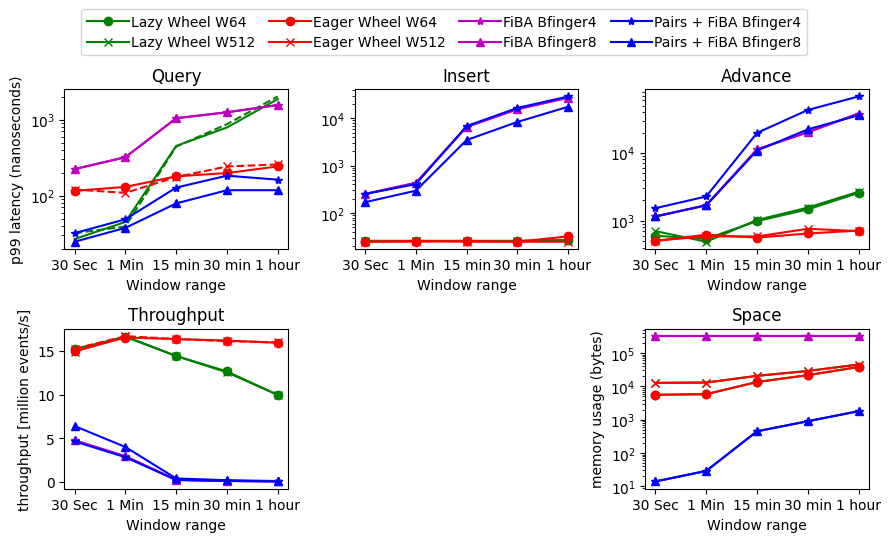

In [591]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.patches as pat
import matplotlib.path as pth
import matplotlib.patheffects as pff
import matplotlib.lines as lns
import matplotlib.transforms as tra

# TODO: read results from file and plot

st=plt.suptitle(r'')
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
x=['30 Sec','1 Min', '15 min', '30 min', '1 hour']

plt.subplot(2,3,1)
plt.title(r'Query')
plt.ylabel(r'p99 latency (nanoseconds)')
plt.gca().set_yscale('log')
plt.xlabel(r'Window range')
y=np.array([26.844465437413014,45.153915815168446,450.4079269124312,788.531491561302,1863.4800488079172,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g')
y=np.array([32.138852969504235,39.254745374189724,441.4889580626803,871.4649775130857,2018.68922123101,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',linestyle='dashed')
y=np.array([115.59680764552776,130.33555804543147,179.4906303359779,198.36848598125036,242.28943126396913,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([120.31456328864704,108.8647558933244,175.93636042833486,242.28943126396913,257.27228753270765,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x', linestyle='dashed')
y=np.array([223.66073809127266,320.58336199659306,1043.3392628236475,1249.111376174664,1556.500034739868,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([223.66073809127266,320.58336199659306,1043.3392628236475,1249.111376174664,1556.500034739868,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([32.138852969504235,48.91478350453143,127.75465590591793,183.11670367609872,162.40929711714284,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([24.780498769903684,37.715494501758016,79.05119439536561,117.93209668887181,117.93209668887181,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')

plt.subplot(2,3,2)
plt.title(r'Insert')
plt.gca().set_yscale('log')
plt.xlabel(r'Window range')
y=np.array([25.791844500743544,25.791844500743544,25.791844500743544,25.791844500743544,26.844465437413014,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g',marker='o')
y=np.array([25.791844500743544,25.791844500743544,25.791844500743544,25.791844500743544,26.844465437413014,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',marker='x')
y=np.array([24.780498769903684,24.780498769903684,25.791844500743544,24.780498769903684,32.138852969504235,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([24.780498769903684,25.791844500743544,24.780498769903684,24.780498769903684,24.780498769903684,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x')
y=np.array([252.17778678948565,432.74660245747856,6569.828548905129,15526.005690315036,27181.45861441203,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([252.17778678948565,432.74660245747856,6569.828548905129,15526.005690315036,27181.45861441203,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([252.17778678948565,407.54458708463767,6837.9574561148,16486.113238019683,28862.323873246656,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([169.03757166533774,295.9349526303603,3464.1469140757617,8351.955779941116,17505.5925598655,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')

plt.subplot(2,3,3)
plt.title(r'Advance')
plt.gca().set_yscale('log')
plt.xlabel(r'Window range')
y=np.array([595.9537183534419,539.2394262082521,982.5779489474648,1465.8535973546166,2566.277488622579,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g',marker='o')
y=np.array([699.3618972397379,487.9223836052193,1022.6790794013975,1556.500034739868,2671.012821287514,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',marker='x')
y=np.array([497.77940145582954,620.2758780658565,561.2469530405447,645.5906777012347,713.4904204162985,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([507.83555098018996,584.1526546236706,584.1526546236706,757.6117193208825,699.3618972397379,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x')
y=np.array([1153.07205475692,1686.1408551087416,11274.07381697815,20136.318429988576,38188.9576200261,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([1153.07205475692,1686.1408551087416,11274.07381697815,20136.318429988576,38188.9576200261,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([1525.6782518737314,2276.074846082655,19737.579451176913,43058.101724074644,68208.26469914839,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([1153.07205475692,1686.1408551087416,10831.996616037934,22254.147710753925,35964.93392683659,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')

plt.subplot(2,3,4)
plt.title(r'Throughput')
plt.ylabel(r'throughput [million events/s]')
plt.xlabel(r'Window range')
y=np.array([15.249784923443933,16.62999881593632,14.44442126764091,12.670389243642921,9.97650238921368,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g',marker='o')
y=np.array([14.939750534020545,16.703622690433306,14.441540737999492,12.56480806608148,9.991682792814617,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',marker='x')
y=np.array([14.992133891079995,16.56382759348927,16.381115798097593,16.215863135153338,15.961077952552603,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([15.269009289641138,16.716434793227684,16.392046593028358,16.141985315308155,15.99346879644346,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x', linestyle='dashed')
y=np.array([4.772945710638424,2.9388783005612846,0.2384517823909469,0.1197837208070601,0.060910846522763136,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([4.772945710638424,2.9388783005612846,0.2384517823909469,0.1197837208070601,0.060910846522763136,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([4.646441942800294,2.837291142674354,0.2247703023138991,0.11106391149996006,0.05530705487866415,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([6.410912381336375,4.008346776063395,0.3984282220024642,0.20249729513374778,0.1029318088446229,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')

plt.subplot(2,3,6)
plt.title(r'Space')
plt.ylabel(r'memory usage (bytes)')
plt.gca().set_yscale('log')
plt.xlabel(r'Window range')
y=np.array([5576,5832,13512,21704,38088,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g',marker='o')
y=np.array([12744,13000,20680,28872,45256,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',marker='x')
y=np.array([5576,5832,13512,21704,38088,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([12744,13000,20680,28872,45256,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x')
y=np.array([320642,320642,320642,320642,320642,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([320642,320642,320642,320642,320642,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([14,29,449,899,1799,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([14,29,449,899,1799,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')
coo=[-0.9,3,]
h,l=plt.gca().get_legend_handles_labels()
g=plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(-0.9, 3.0),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
plt.gcf().set_size_inches(10.377750103777501,5.1888750518887505)

plt.savefig("debs12.pdf", format="pdf", bbox_inches="tight")


# NYC Citi Bike Streaming Window Aggregation

## Growing Range

In [592]:
file_path = 'results/nyc_citi_bike.json' 
nyc_citi_json = read_json_data(file_path)

if json_data:
    print_streaming_eval(nyc_citi_json)

ID: nyc_citi_bike
Range: 30s, Slide: 2s
System ID: Lazy Wheel 64, Throughput: 0.7542754554183309, Runtime: 10.620228913
AVG Insert: 31.58038408714078, AVG Query: 45.75490318598156, AVG Advance: 117998.32566848925
P50 Insert Latency: 22.875222481777083, P50 Query Latency: 45.153915815168446, P50 Advance Latency: 83310.3180664542
P95 Insert Latency: 70.11183939140403, P95 Query Latency: 68.72348613612868, P95 Advance Latency: 324607.8193248326
System ID: Lazy Wheel 512, Throughput: 1.5099208980812049, Runtime: 5.305296463
AVG Insert: 24.56312852830345, AVG Query: 37.07605793408961, AVG Advance: 53394.869210795696
P50 Insert Latency: 21.978242872649467, P50 Query Latency: 36.236600491297935, P50 Advance Latency: 27181.45861441203
P95 Insert Latency: 26.844465437413014, P95 Query Latency: 60.95202051338155, P95 Advance Latency: 142963.65096980496
System ID: Eager Wheel W64, Throughput: 0.7414602638181694, Runtime: 10.803785976
AVG Insert: 30.556613268106247, AVG Query: 191.3667829120761, A

## Distribution

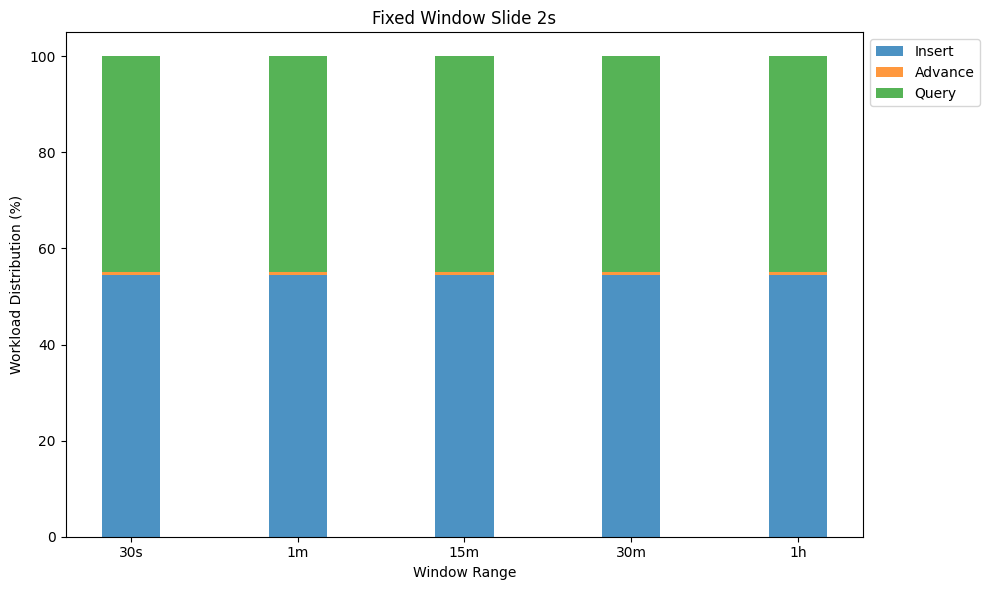

In [593]:
plot_workload_distribution(nyc_citi_json, True)

## Throughput

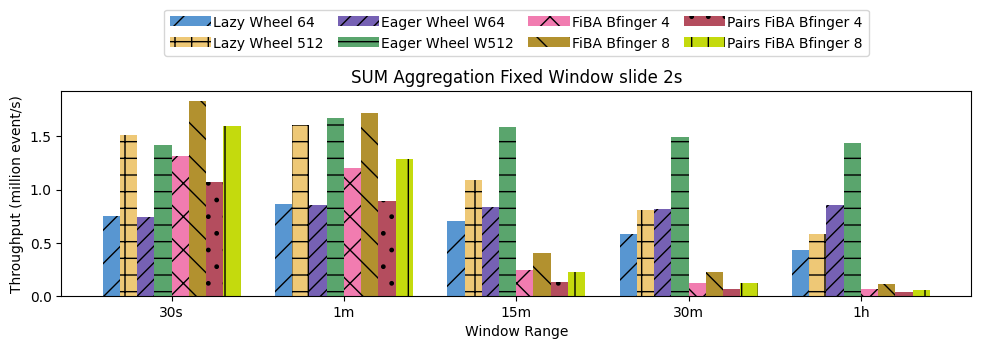

In [594]:
plot_throughput(nyc_citi_json, True)


### Analysis

In this dataset there is a larger gap in the throughput of wheels with write-ahead of 64 or 512 units (seconds).
This is due to receving timestamps that are further ahead than 64 seconds of the watermark and these events are scheduled in the 
internal timing wheel to be aggregated in the future. This process requires on-demand heap allocation and is more costly than aggregating directly into the write-ahead wheel.

TODO: Log overflow schedules to see actually how man events are scheduled in the timing wheel

## Latency

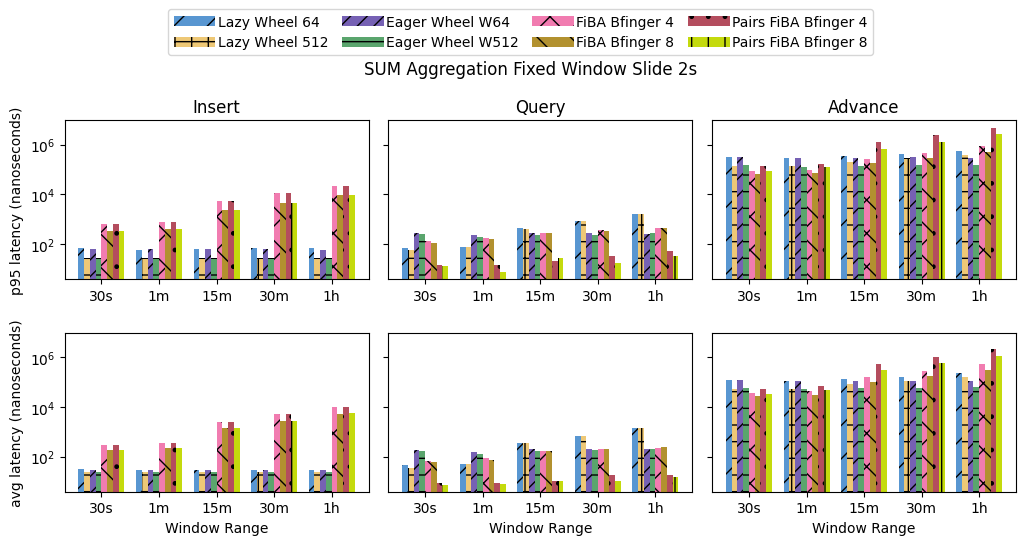

In [595]:
plot_latency(nyc_citi_json, True)


## Growing Slide

In [596]:
file_path = 'results/nyc_citi_bike_growing_slide.json' 
nyc_citi_growing_slide_json = read_json_data(file_path)

if json_data:
    print_streaming_eval(nyc_citi_growing_slide_json)

ID: nyc_citi_bike
Range: 30m, Slide: 2s
System ID: Lazy Wheel 64, Throughput: 0.7920313266740661, Runtime: 10.113966115
AVG Insert: 29.012407718893694, AVG Query: 695.8556034133819, AVG Advance: 119279.6956033256
P50 Insert Latency: 22.875222481777083, P50 Query Latency: 685.5131467993475, P50 Advance Latency: 88462.11736195315
P95 Insert Latency: 58.561979516876, P95 Query Latency: 820.7131665561515, P95 Advance Latency: 299649.9850680329
System ID: Lazy Wheel 512, Throughput: 1.214860142496161, Runtime: 6.593827322
AVG Insert: 24.12525725359643, AVG Query: 697.7163506562188, AVG Advance: 76070.46040246674
P50 Insert Latency: 21.978242872649467, P50 Query Latency: 685.5131467993475, P50 Advance Latency: 45720.757482400666
P95 Insert Latency: 26.844465437413014, P95 Query Latency: 820.7131665561515, P95 Advance Latency: 178144.9852634474
System ID: Eager Wheel W64, Throughput: 1.351599509086763, Runtime: 5.926739353
AVG Insert: 27.88625402561463, AVG Query: 119.19400153888174, AVG Adva

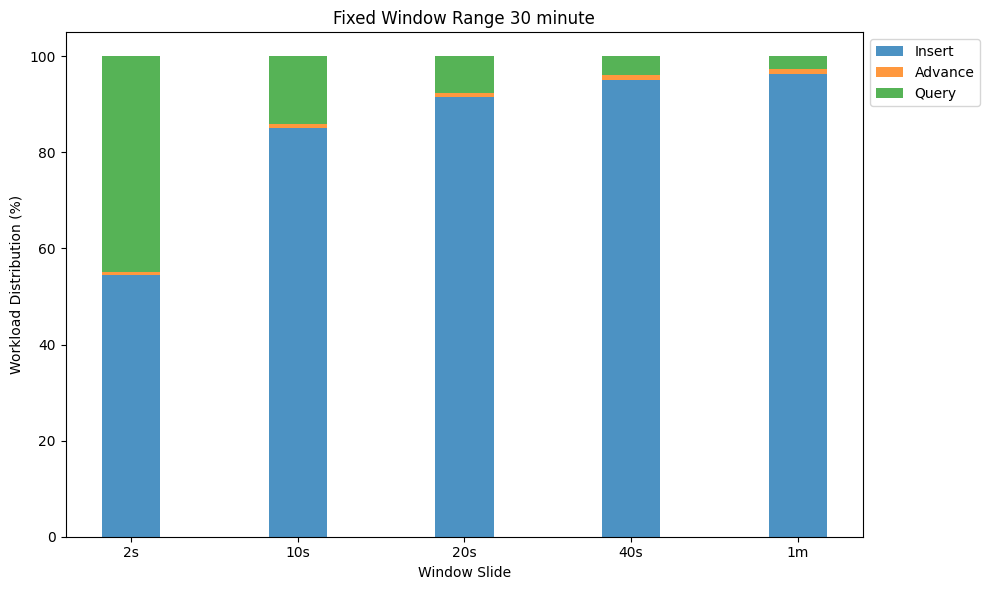

In [597]:
plot_workload_distribution(nyc_citi_growing_slide_json, False)

### Analysis

In contrast to the DEBS12 dataset, NYC Citi Bike does not have as high insert rate per second and this leads to more even distribution between inserts and queries. However, as seen in the figure, the insert % grows when the number of concurrent windows decrease.

Summary: The workload that dominates the execution is inserts

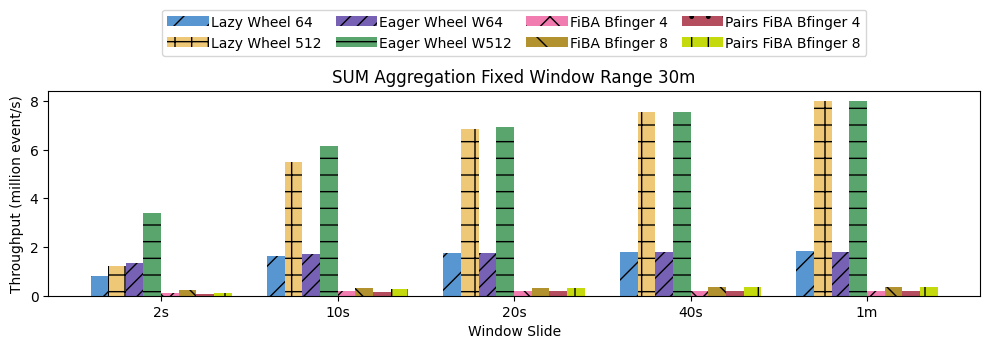

In [598]:
plot_throughput(nyc_citi_growing_slide_json, False)


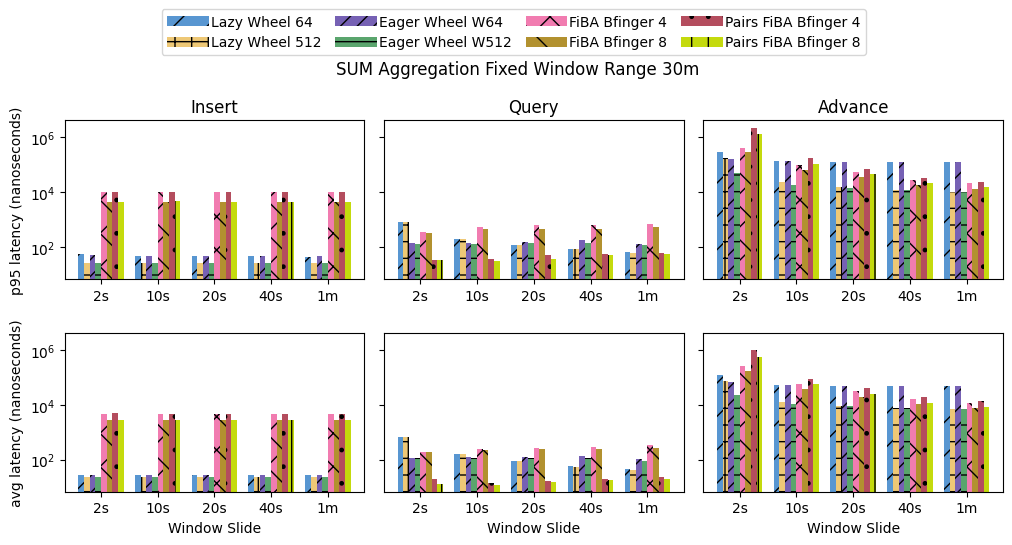

In [599]:
plot_latency(nyc_citi_growing_slide_json, False)


# Takeaways

1. For both datasets (NYC Citi Bike and DEBS12) inserts dominate the execution.
2. FiBA is not explicitly designed for time-based windows and does not roll-up and compact temporal aggregates over time leading to worse performance when window range grows
3. Wheels acheive a stable avg latency for inserts by decoupling writes/reads and peforming lazy index maintenance when the low watermark advances
4. If the aggregate function is invertible then eager wheels supports both great insert and query performance over varying window specs
